# Recurrent Neural Network - Word Classification
## Using Special model
Implemented in TensorFlow. Using Seq2Seq to generate the sequence of letter images and recognise them by RNN.
## TODO
```
Overlaping sliders
CNN preprocessing
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow as tf
import tensorflow.contrib.seq2seq as seq2seq
from tensorflow.python.layers import core as layers_core
from tensorflow.python.ops import math_ops
import time
import math
import unidecode

from ocr.datahelpers import loadWordsData, correspondingShuffle
from ocr.helpers import implt, extendImg, resize
from ocr.mlhelpers import TrainingPlot
from ocr.normalization import letterNorm, imageStandardization
from ocr.tfhelpers import Graph, create_cell

%matplotlib notebook
# Increase size of images
plt.rcParams['figure.figsize'] = (9.0, 5.0)

tf.reset_default_graph()
sess = tf.InteractiveSession()
print('Tensorflow', tf.__version__)

Tensorflow 1.4.0


### Loading images

In [ ]:
LANG = 'en'

In [ ]:
images, labels, gaplines = loadWordsData(['data/words/'],
                               loadGaplines=True)

if LANG == 'en':
    for i in range(len(labels)):
        labels[i] = unidecode.unidecode(labels[i])

Loading words...


In [ ]:
CHARS = ['A', 'a', 'Á', 'á', 'B', 'b', 'C', 'c', 'Č', 'č',
         'D', 'd', 'Ď', 'ď', 'E', 'e', 'É', 'é', 'Ě', 'ě',
         'F', 'f', 'G', 'g', 'H', 'h', 'I', 'i', 'Í', 'í',         
         'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n',
         'Ň', 'ň', 'O', 'o', 'Ó', 'ó', 'P', 'p', 'Q', 'q',
         'R', 'r', 'Ř', 'ř', 'S', 's', 'Š', 'š', 'T', 't',
         'Ť', 'ť', 'U', 'u', 'Ú', 'ú', 'Ů', 'ů', 'V', 'v',
         'W', 'w', 'X', 'x', 'Y', 'y', 'Ý', 'ý', 'Z', 'z',
         'Ž', 'ž']
if LANG == 'en':
    CHARS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
             'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
             'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
             'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
             'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
             'x', 'y', 'z']

print("Number of chars:", len(CHARS))

## Settings

In [ ]:
PAD = 0   # Padding
EOS = 1   # End of seq
LETTER_PAD = -1.0

num_buckets = 5
slider_size = (60, 2)
slider_step = 2
N_INPUT = slider_size[0]*slider_size[1]
char_size = len(CHARS) + 2
letter_size = 64*64

encoder_layers = 1
encoder_residual_layers = 0        # HAVE TO be smaller than encoder_layers
encoder_units = 256

decoder_layers = 2*encoder_layers  # 2* is due to the bidirectional encoder
decoder_residual_layers = 2*encoder_residual_layers
decoder_units = encoder_units

wordRNN_layers = 2
wordRNN_residual_layers = 1
wordRNN_units = 128

attention_size = 256

add_output_length = 4

learning_rate = 1e-3               # 1e-4
max_gradient_norm = 5.0            # For gradient clipping
dropout = 0.4
train_per = 0.8                    # Percentage of training data

TRAIN_STEPS = 1000000               # Number of training steps!
TEST_ITER = 150
LOSS_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 16                    # 64
EPOCH = 1000                       # Number of batches in epoch - not accurate
save_location = 'models/word-clas/' + LANG + '/SeqRNN/Classifier'

## Dataset

In [ ]:
# Shuffle data for later splitting
images, labels, gaplines = correspondingShuffle([images, labels, gaplines])

idxs = [i+1 for i in range(char_size)]
idx_to_chars = dict(zip(idxs, CHARS))
chars_to_idx = dict(zip(CHARS, idxs))

labels_idx = np.empty(len(labels), dtype=object)
for i, label in enumerate(labels):
    labels_idx[i] = [chars_to_idx[c] for c in label]
    labels_idx[i].append(EOS)

# Split data on train and test dataset
div = int(train_per * len(images))

trainImages = images[0:div]
testImages = images[div:]

trainGaplines = gaplines[0:div]
testGaplines = gaplines[div:]

trainLabels_idx = labels_idx[0:div]
testLabels_idx = labels_idx[div:]

print("Training images:", div)
print("Testing images:", len(images) - div)

In [ ]:
def stackImage(img, a, b):
    """ Add blank columns (lenght a, b) at start and end of image """
    return np.concatenate(
        (np.zeros((img.shape[0], a)),
         np.concatenate((img, np.zeros((img.shape[0], b))), axis=1)),
        axis=1)
    
# Dont mix train and test images
num_new_images = 4 # 2
trainImagesF = np.empty(len(trainImages) * (num_new_images+1), dtype=object)
trainGaplinesF = np.empty(len(trainImages) * (num_new_images+1), dtype=object)
trainLabelsF_idx = np.empty(len(trainImages)*(num_new_images+1), dtype=object)
for idx, img in enumerate(trainImages):
    add_idx = idx*(num_new_images+1)
    trainImagesF[add_idx] = img
    trainGaplinesF[add_idx] = trainGaplines[idx]
    trainLabelsF_idx[add_idx] = trainLabels_idx[idx]
    for i in range(num_new_images):
        a, b = np.random.randint(1, 16, size=2)
        trainImagesF[add_idx + (i+1)] = stackImage(img, a, b)
        trainGaplinesF[add_idx + (i+1)] = trainGaplines[idx] + a
        trainLabelsF_idx[add_idx + (i+1)] = trainLabels_idx[idx]
        
print("Total train images", len(trainImagesF))

In [ ]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self,
                 images,
                 targets,
                 gaplines,
                 num_buckets=5,
                 slider=(60, 30),
                 slider_step=2,
                 train=True):
        
        self.train = train
        self.slider = slider
        
        # PADDING of images to slider size ( -(a // b) ==  ceil(a/b))
        for i in range(len(images)):
            images[i] = extendImg(
                images[i],
                (images[i].shape[0], -(-images[i].shape[1] // slider[1]) * slider[1]))
        in_length = [image.shape[1]//slider[1] for image in images]
        
        # Split images to sequence of vectors
        img_seq = np.empty(len(images), dtype=object)
        for i, img in enumerate(images):
            img_seq[i] = [imageStandardization(
                img[:, loc * slider[1]: (loc+1) * slider[1]]).flatten()
                          for loc in range(in_length[i])]
            
        end_letter = np.ones(letter_size) # * LETTER_PAD # End letter is full white
        np.put(end_letter, [0], [1])
        letter_seq = np.empty(len(images), dtype=object)
        for i, img in enumerate(images):
            letter_seq[i] = [imageStandardization(
                letterNorm(img[:, gaplines[i][x]:gaplines[i][x+1]])).flatten()
                             for x in range(len(gaplines[i])-1)]
            letter_seq[i].append(end_letter)

        # Create pandas dataFrame and sort it by images width (length)
        # letters_length is num_letter + EOS
        self.dataFrame = pd.DataFrame({'in_length': in_length,
                                       'letters_length': [len(g) for g in gaplines],
                                       'words_length': [len(t) for t in targets],
                                       'in_images': img_seq,
                                       'letters': letter_seq,
                                       'words': targets
                                      }).sort_values('in_length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        
        # Create buckets by slicing parts by indexes
        self.buckets = []
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket * bsize: (bucket+1) * bsize])
        self.buckets.append(self.dataFrame.iloc[(num_buckets-1) * bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.bucket_order = np.random.permutation(num_buckets)
        self.bucket_cursor = 0
        self.shuffle()
        print("Iterator created.")

        
    def shuffle(self, idx=None):
        """ Shuffle idx bucket or each bucket separately """
        for i in [idx] if idx is not None else range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0


    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: (in_images, letters, words,
                  in_length, letter_length, word_length)
        """
        i_bucket = self.bucket_order[self.bucket_cursor]
        # Increment cursor and shuffle in case of new round
        self.bucket_cursor = (self.bucket_cursor + 1) % self.num_buckets
        if self.bucket_cursor == 0:
            self.bucket_order = np.random.permutation(self.num_buckets)
            
        if self.cursor[i_bucket] + batch_size > self.buckets_size[i_bucket]:
            self.shuffle(i_bucket)

        # Handle too big batch sizes
        if (batch_size > self.buckets_size[i_bucket]):
            batch_size = self.buckets_size[i_bucket]

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size
        
        # Check correct length of later prediction of sequences
        assert np.all(res['in_length'] + add_output_length >= res['letters_length'])

        input_max = max(res['in_length'])
        letters_max = max(res['letters_length'])
        words_max = max(res['words_length'])        
        
        input_seq = np.ones((batch_size, input_max, N_INPUT), dtype=np.float32) * LETTER_PAD
        for i, img in enumerate(res['in_images']):
            input_seq[i][:res['in_length'].values[i]] = img
        input_seq = input_seq.swapaxes(0, 1)    # Time major
        
        letters = np.ones((batch_size, letters_max, letter_size), dtype=np.float32) * LETTER_PAD
        for i, img in enumerate(res['letters']):
            letters[i][:res['letters_length'].values[i]] = img
        
        # Need to pad according to the maximum length output sequence
        words = np.zeros([batch_size, words_max], dtype=np.int32)
        for i, word in enumerate(res['words']):
            words[i][:res['words_length'].values[i]] = word
        
        return (input_seq, letters, words,
                res['in_length'].values, res['letters_length'].values, res['words_length'].values)


    def next_feed(self, size, words=True, train=None):
        """ Create feed directly for model training """
        if train is None:
            train = self.train
        (encoder_inputs_,
         letter_targets_,
         word_targets_,
         encoder_inputs_length_,
         letter_targets_length_,
         word_targets_length_) = self.next_batch(size)
        return {
            encoder_inputs: encoder_inputs_,
            encoder_inputs_length: encoder_inputs_length_,
            letter_targets: letter_targets_,
            letter_targets_length: letter_targets_length_,
            word_targets: word_targets_,
            word_targets_length: word_targets_length_,
            keep_prob: (1.0 - dropout) if self.train else 1.0,
            is_training: train,
            is_words: words
        }

In [ ]:
# Create iterator for feeding RNN
# Create only once, it modifies: labels_idx
train_iterator = BucketDataIterator(trainImagesF,
                                    trainLabelsF_idx,
                                    trainGaplinesF,
                                    num_buckets,
                                    slider_size,
                                    slider_step,
                                    train=True)
test_iterator = BucketDataIterator(testImages,
                                   testLabels_idx,
                                   testGaplines,
                                   num_buckets,
                                   slider_size,
                                   slider_step,
                                   train=False)

## Placeholders

In [ ]:
# Only encoder inputs are time major
# Encoder inputs shape (max_seq_length, batch_size, vec_size)
encoder_inputs = tf.placeholder(shape=(None, None, N_INPUT),
                                dtype=tf.float32,
                                name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,),
                                       dtype=tf.int32,
                                       name='encoder_inputs_length')

# Required for letter sep. training
# Contains EOS symbol
letter_targets = tf.placeholder(shape=(None, None, letter_size),
                                dtype=tf.float32,
                                name='letter_targets')
letter_targets_length = tf.placeholder(shape=(None,),
                                       dtype=tf.int32,
                                       name='letter_targets_length')

# Required for word training
word_targets = tf.placeholder(shape=(None, None),
                              dtype=tf.int32,
                              name='word_targets')
word_targets_length = tf.placeholder(shape=(None,),
                                     dtype=tf.int32,
                                     name='word_targets_length')
# Dropout value
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
# Testing control
is_training = tf.placeholder(tf.bool, shape=None, name="is_training")
is_words = tf.placeholder(tf.bool, shape=None, name="is_words")

### Decoder Train Feeds

In [ ]:
sequence_size, batch_size, _ = tf.unstack(tf.shape(encoder_inputs)) # letter_targets

EOS_SLICE = tf.cast(tf.fill([batch_size, 1, letter_size], EOS), tf.float32)
PAD_SLICE = tf.cast(tf.fill([batch_size, 1, letter_size], LETTER_PAD), tf.float32) # PAD

# Train inputs with EOS symbol at start of seq
letter_train_inputs = tf.concat([PAD_SLICE, letter_targets], axis=1) #EOS_SLICE
letter_train_length = letter_targets_length

# Length of infer (test) letter output
# TODO: will have to make shorte...
output_length = tf.minimum(
    tf.reduce_max(encoder_inputs_length) * slider_size[1] // 15 + add_output_length,
    23)

## Encoder

In [ ]:
enc_cell_fw = create_cell(encoder_units,
                          encoder_layers,
                          encoder_residual_layers,
                          is_dropout=True,
                          keep_prob=keep_prob)
enc_cell_bw = create_cell(encoder_units,
                          encoder_layers,
                          encoder_residual_layers,
                          is_dropout=True,
                          keep_prob=keep_prob)

In [ ]:
inputs = encoder_inputs

# Bidirectional RNN, gibe fw and bw outputs separately
enc_outputs, enc_state = tf.nn.bidirectional_dynamic_rnn(
    cell_fw = enc_cell_fw,
    cell_bw = enc_cell_bw,
    inputs = inputs,
    sequence_length = encoder_inputs_length,
    dtype = tf.float32,
    time_major = True)

encoder_outputs = tf.concat(enc_outputs, -1)

if encoder_layers == 1:
    encoder_state = enc_state
else:
    encoder_state = []
    for layer_id in range(encoder_layers):
        encoder_state.append(enc_state[0][layer_id])  # forward
        encoder_state.append(enc_state[1][layer_id])  # backward
    encoder_state = tuple(encoder_state)

## Decoder

In [ ]:
# attention_states: size [batch_size, max_time, num_units]
attention_states = tf.transpose(encoder_outputs, [1, 0, 2])

# Create an attention mechanism
attention_mechanism = seq2seq.BahdanauAttention(
    attention_size, attention_states,              # decoder_units instead of attention_size
    memory_sequence_length=encoder_inputs_length)

decoder_cell = create_cell(decoder_units,
                           decoder_layers,
                           decoder_residual_layers,
                           is_dropout=True,
                           keep_prob=keep_prob)

decoder_cell = seq2seq.AttentionWrapper(
    decoder_cell, attention_mechanism,
    attention_layer_size=attention_size)

decoder_initial_state = decoder_cell.zero_state(batch_size, tf.float32).clone(
    cell_state=encoder_state)

#### TRAIN DECODER

In [ ]:
# Helper
helper = seq2seq.TrainingHelper(
    letter_train_inputs, letter_targets_length)

# Decoder
projection_layer = layers_core.Dense(
    letter_size, activation=tf.tanh, use_bias=True)

decoder = seq2seq.BasicDecoder(
    decoder_cell, helper, decoder_initial_state,
    output_layer=projection_layer)

# Dynamic decoding
outputs, final_context_state, _ = seq2seq.dynamic_decode(
    decoder)

letter_logits_train = outputs.rnn_output
letter_prediction_train = outputs.sample_id

#### INFERENCE DECODER

In [ ]:
### CNN ###
SCALE = 0.01 # 0.1
# Functions for initializing convulation and pool layers
def weights(name, shape):
    return tf.get_variable(name, shape=shape,
                           initializer=tf.contrib.layers.xavier_initializer(),
                           regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE))

def bias(const, shape, name=None):
    return tf.Variable(tf.constant(const, shape=shape), name=name)

def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def conv2d2(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

def inception2d(x, in_channels, filter_count, var_dict):
    # 1x1
    one_by_one = conv2d(x, var_dict['one_filter']) + var_dict['one_bias']
    # 3x3
    three_by_three = conv2d(x, var_dict['three_filter']) + var_dict['three_bias']
    # 5x5
    five_by_five = conv2d(x, var_dict['five_filter']) + var_dict['five_bias']
    # avg pooling
    pooling = tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')
    x = tf.concat([one_by_one, three_by_three, five_by_five, pooling], axis=3)  # Concat in the 4th dim to stack
    return tf.nn.relu(x)


in_channels1 = 4
filter_count1 = 12

in_channels2 = 40
filter_count2 = 20

W_conv1 = weights('W_conv1', shape=[16, 16, 1, 4])
b_conv1 = bias(0.1, shape=[4], name='b_conv1')
W_fc1 = weights('W_fc2', shape=[8*8*100, char_size])
b_fc1 = bias(0.1, shape=[char_size], name='b_fc2')

var_dict1 = {
    'one_filter': weights('one_filter1',shape=[1, 1, in_channels1, filter_count1]),
    'one_bias': bias(0.2, shape=[filter_count1]),
    'three_filter': weights('three_filter1', shape=[3, 3, in_channels1, filter_count1]),
    'three_bias': bias(0.2, shape=[filter_count1]),
    'five_filter': weights('five_filter1', shape=[5, 5, in_channels1, filter_count1]),
    'five_bias': bias(0.2, shape=[filter_count1])
}

var_dict2 = {
    'one_filter': weights('one_filter2',shape=[1, 1, in_channels2, filter_count2]),
    'one_bias': bias(0.2, shape=[filter_count2]),
    'three_filter': weights('three_filter2', shape=[3, 3, in_channels2, filter_count2]),
    'three_bias': bias(0.2, shape=[filter_count2]),
    'five_filter': weights('five_filter2', shape=[5, 5, in_channels2, filter_count2]),
    'five_bias': bias(0.2, shape=[filter_count2])
}


def CNN(x):
    b_size, seq_size, _ = tf.unstack(tf.shape(x))
    imgs = tf.reshape(x, [-1, 64, 64, 1])
    # 1. Layer - Convulation
    h_conv1 = tf.nn.relu(conv2d2(imgs, W_conv1) + b_conv1, name='h_conv1')    
    # 2. Layer - Max Pool
    h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')
    # 3. Inception
    incept1 = inception2d(h_pool1, in_channels1, filter_count1, var_dict1)
    # 4. Inception
    incept2 = inception2d(incept1, in_channels2, filter_count2, var_dict2)
    # 5. Layer - Max Pool
    h_pool3 = max_pool_2x2(incept2)
    # Reshape filters into flat arraty
    h_flat = tf.reshape(h_pool3, [-1, 8*8*100])
    # 6. Dropout
    h_flat_drop = tf.nn.dropout(h_flat, keep_prob)
    # 7. Output layer
    out = tf.matmul(h_flat_drop, W_fc1) + b_fc1
    return tf.reshape(out, [b_size, seq_size, -1])

In [ ]:
# Helper without embedding, can add param: 'next_inputs_fn'
helper_infer = seq2seq.InferenceHelper(
    sample_fn=(lambda x: x),
    sample_shape=[letter_size],
    sample_dtype=tf.float32,
    start_inputs=tf.cast(tf.fill([batch_size, letter_size], LETTER_PAD), tf.float32), # PAD <- EOS, need flaot32
    end_fn=(lambda sample_ids:
            tf.greater(sample_ids[:, 0], 0)))
            
            

decoder_infer = seq2seq.BasicDecoder(
    decoder_cell, helper_infer, decoder_initial_state,
    output_layer=projection_layer)

# Dynamic decoding
outputs_infer, final_context_state, final_seq_lengths = seq2seq.dynamic_decode(
    decoder_infer,
    impute_finished=True,
    maximum_iterations=output_length)

letter_prediction_infer = tf.identity(outputs_infer.rnn_output, # sample_id
                                      name='letter_prediction_infer')

## RNN

In [ ]:
# cell_RNN = create_cell(wordRNN_units,
#                        wordRNN_layers,
#                        wordRNN_residual_layers,
#                        is_dropout=True,
#                        keep_prob=keep_prob)

word_inputs = tf.cond(is_training,
                      lambda: letter_targets,
                      lambda: letter_prediction_infer)
word_inputs_length_ = tf.cond(is_training,
                              lambda: letter_targets_length,
                              lambda: final_seq_lengths)

word_inputs_length = word_inputs_length_    # tf.subtract(word_inputs_length_, 1)


# Word RNN
# word_outputs, _ = tf.nn.dynamic_rnn(
#     cell = cell_RNN,
#     inputs = word_inputs,
#     sequence_length = word_inputs_length,
#     dtype = tf.float32)


# Input images CNN
word_outputs = CNN(word_inputs)
# tf.map_fn(
#     lambda seq: tf.map_fn(
#         lambda img:
#             tf.reshape(CNN(tf.reshape(img, [1, 64, 64, 1])), [-1]),
#         seq),
#     word_inputs,
#     dtype=tf.float32)


# word_logits = tf.layers.dense(
#     inputs=word_outputs,
#     units=char_size,
#     name='pred')
word_logits = word_outputs
word_prediction = tf.argmax(
    word_logits, axis=-1, output_type=tf.int32,    # word_logits
    name='word_prediction')

## Optimizer

#### Weights + Paddings

In [ ]:
# Pad test accuracy
letter_test_targets = tf.pad(
    letter_targets,
    [[0, 0],
     [0, output_length - tf.reduce_max(letter_targets_length)],
     [0, 0]],
    constant_values=LETTER_PAD,
    mode='CONSTANT')

# Pad prediction to match lengths
letter_pred_infer_pad = tf.pad(
    letter_prediction_infer,
    [[0, 0],
     [0, output_length - tf.reduce_max(word_inputs_length_)],
     [0, 0]],
    constant_values=LETTER_PAD,
    mode='CONSTANT')


word_pad_lenght = tf.maximum(
    tf.reduce_max(word_inputs_length_),
    tf.reduce_max(word_targets_length))

word_logits_pad = tf.pad(
    word_logits,
    [[0, 0],
     [0, word_pad_lenght - tf.reduce_max(word_inputs_length_)],
     [0, 0]],
    constant_values=PAD,
    mode='CONSTANT')
word_pred_pad = tf.pad(
    word_prediction,
    [[0, 0],
     [0, word_pad_lenght - tf.reduce_max(word_inputs_length_)]],
    constant_values=PAD,
    mode='CONSTANT')
word_targets_pad = tf.pad(
    word_targets,
    [[0, 0],
     [0, word_pad_lenght - tf.reduce_max(word_targets_length)]],
    constant_values=PAD,
    mode='CONSTANT')


# Weights
letter_loss_weights = tf.sequence_mask(
    letter_train_length,
    tf.reduce_max(letter_train_length),
    dtype=tf.float32)

letter_test_weights = tf.sequence_mask(
    letter_train_length,
    output_length,
    dtype=tf.float32)

word_loss_weights = tf.sequence_mask(
    word_targets_length,    # word_inputs_length, try max(targets, inputs)
    word_pad_lenght,
    dtype=tf.float32)

In [ ]:
## Loss
letter_loss = tf.losses.mean_squared_error(
    predictions=letter_logits_train,
    labels=letter_targets,
    weights=tf.stack([letter_loss_weights for i in range(letter_size)], axis=-1))

word_seq_loss = seq2seq.sequence_loss(
    logits=word_logits_pad,
    targets=word_targets_pad,
    weights=word_loss_weights,
    name='word_loss')
regularization = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
word_loss = word_seq_loss + sum(regularization)


loss = tf.cond(is_words,
               lambda: word_loss,
               lambda: letter_loss)

learning_rate_ = tf.cond(tf.logical_and(is_words, tf.logical_not(is_training)),
                         lambda: learning_rate * 1,  # 0.1
                         lambda: learning_rate)

## Calculate and clip gradients
params = tf.trainable_variables()
gradients = tf.gradients(loss, params)
clipped_gradients, _ = tf.clip_by_global_norm(
    gradients, max_gradient_norm)

### Optimization
optimizer = tf.train.AdamOptimizer(learning_rate_)
train_step = optimizer.apply_gradients(
    zip(clipped_gradients, params),
    name='train_step')

### Evaluate model
correct_prediction = tf.equal(
    word_pred_pad,
    word_targets_pad)
## Advanced accuracy only the elements of seq including EOS symbol
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy = (tf.reduce_sum(tf.cast(correct_prediction, tf.float32) * word_loss_weights) \
            / tf.reduce_sum(word_loss_weights))

In [ ]:
x = tf.placeholder(shape=(None, None, 3), dtype=tf.float32, name='x')
ii = tf.reshape(x, [-1, 2, 2, 1])

In [ ]:
sess.run(tf.global_variables_initializer())
test_arr = np.arange(24).reshape(2, 3, 4)
print(test_arr)
print(ii.eval({x: test_arr}))
fd  = test_iterator.next_feed(32)
pre = word_logits.eval(fd)
print(pre.shape)

## Training

<IPython.core.display.Javascript object>


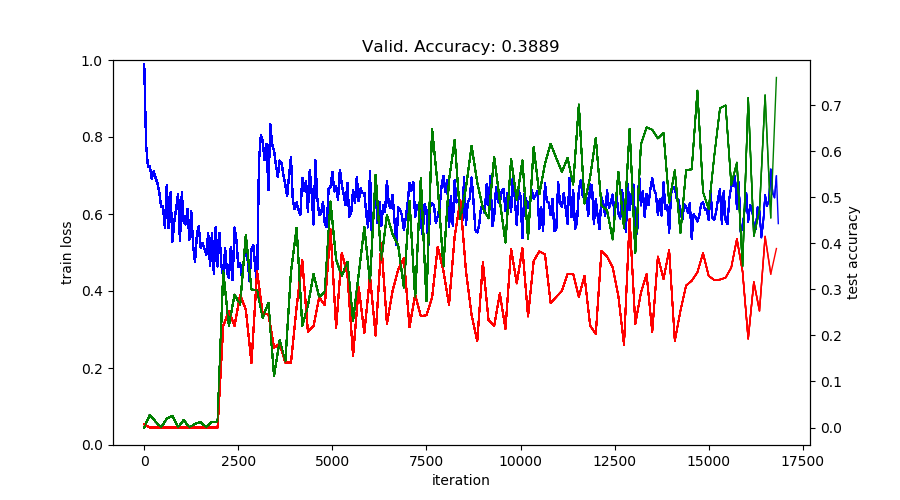

batch 0 - loss: 9.4983988
    expected  > [28 35 46  1  0  0  0  0  0]
    predicted > [50 50 50 50 50 50 50 50 50 50 50 50]
    expected  > [28 27  1  0  0  0  0  0  0]
    predicted > [50 50 50 50 50 50 50 50 50 50 50 50]

batch 1000 - loss: 9.5658579
    expected  > [44 35 36 40 41 48 31 39  1]
    predicted > [25 25 25 25 25 25 50 50 50 50 50 50 50]
    expected  > [39 31  1  0  0  0  0  0  0]
    predicted > [25 25 50 50 50 50 50 50 50 50 50 50 50]

batch 2000 - loss: 9.5477753
    expected  > [39 31 45 46 41  1  0  0  0  0  0  0  0  0  0  0]
    predicted > [25  5 50 25 25 25 50 50 50 50 50 50 50]
    expected  > [28 44 35 46 27 40 35 31  1  0  0  0  0  0  0  0]
    predicted > [25 50 25 25 50 25 50 50 50 50 50 50 50]

batch 3000 - loss: 4.104382
    expected  > [ 5 30 47 27 44 30  1  0  0]
    predicted > [31 31 27 27  1 31  1  1  1  1]
    expected  > [44 35 36 40 41 48 31 39  1]
    predicted > [45 48 51 27 27 27 27  1 31  1]

batch 4000 - loss: 3.0975235
    expected  > [ 9 3

'models/word-clas/en/SeqRNN/Classifier'

In [22]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, LOSS_ITER)

try:
    for i_batch in range(TRAIN_STEPS):
        # Three steps (can overflow): 1. train letters, 2. train words on known letter 3. combine
        is_words_, is_train_ = (True, True)
        if i_batch < 2000 or i_batch % 2 == 0:    # 5000
            is_words_, is_train_ = (False, True)
        elif i_batch < 3000:                      # 12000
            is_words_, is_train_ = (True, True)
        elif i_batch % 8 == 7:
            is_words_, is_train_ = (True, False)

        fd = train_iterator.next_feed(BATCH_SIZE, words=is_words_, train=is_train_)
        train_step.run(fd)
        
        if i_batch % LOSS_ITER == 0:
            # Plotting loss
            tmpLoss = loss.eval(fd)
            trainPlot.updateCost(tmpLoss, i_batch // LOSS_ITER)
    
        if i_batch % TEST_ITER == 0:
            # Plotting accuracy
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            fd = train_iterator.next_feed(BATCH_SIZE, words=True, train=False)
            accTest = accuracy.eval(fd_test)
            accTrain = accuracy.eval(fd)
            trainPlot.updateAcc(accTest, accTrain, i_batch // TEST_ITER)

        if i_batch % SAVE_ITER == 0:
            saver.save(sess, save_location)
        
        if i_batch % EPOCH == 0:
            fd_test = test_iterator.next_feed(BATCH_SIZE)
#             print('batch %r - loss: %r' % (i_batch, sess.run(loss, fd_test)))
#             predict_, target_ = sess.run([letter_prediction_infer, letter_targets], fd_test)
#             for i, (inp, pred) in enumerate(zip(target_, predict_)):
#                 implt(inp[0].reshape((64, 64)), 'gray', t="Expected")
#                 implt(pred[0].reshape((64, 64)), 'gray', t="Predicted")
#                 if i >= 1:
#                     break
            print('batch %r - loss: %r' % (i_batch, sess.run(loss, fd_test)))
            predict_, target_ = sess.run([word_prediction, word_targets], fd_test)
            for i, (inp, pred) in enumerate(zip(target_, predict_)):
                print('    expected  > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 1:
                    break
            print()

except KeyboardInterrupt:
    print('Training interrupted, model saved.')
    
saver.save(sess, save_location)

Expected images: 2


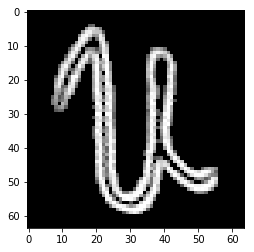

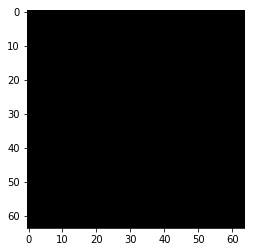

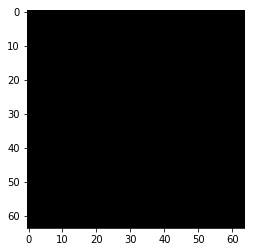

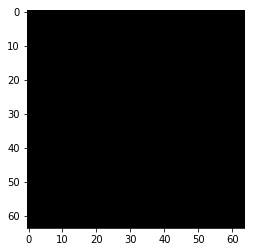

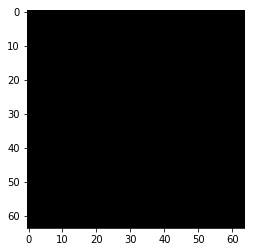

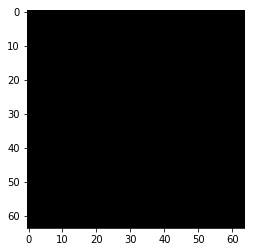

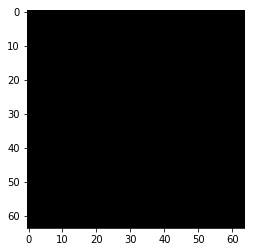

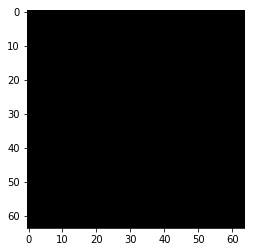

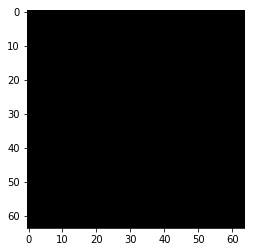

Predicted images: 2


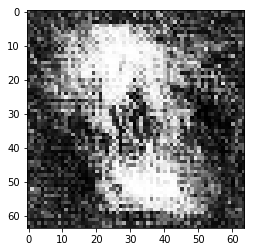

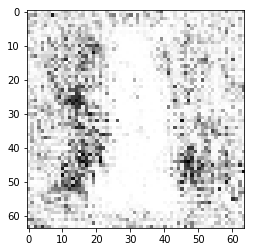

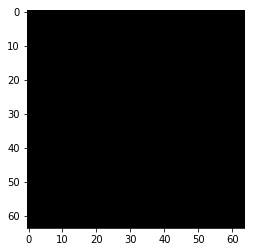

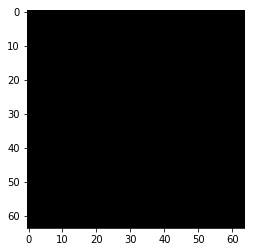

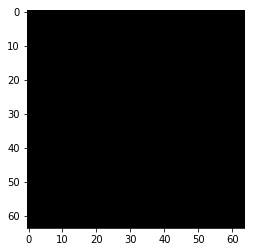

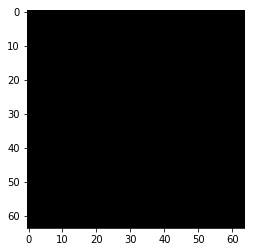

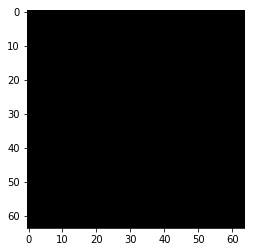

Expected images: 3


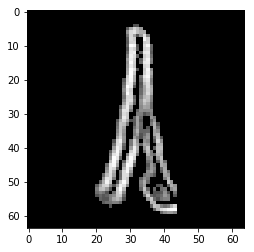

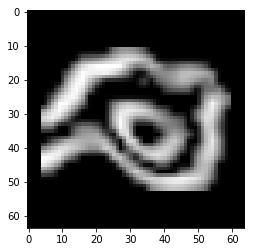

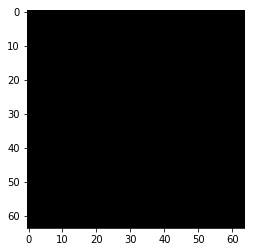

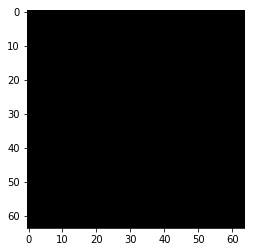

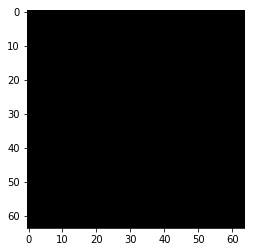

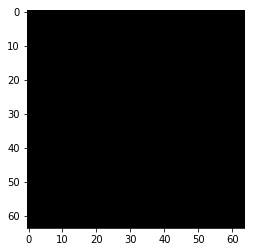

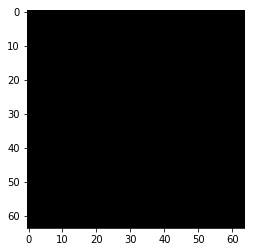

Predicted images: 1


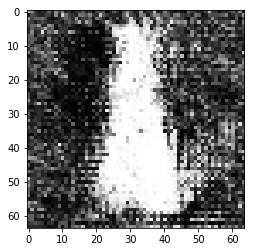

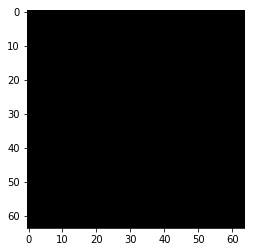

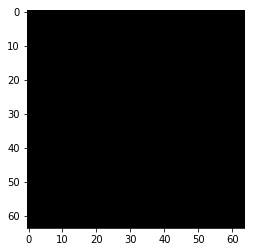

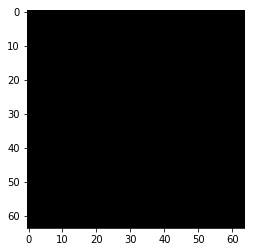

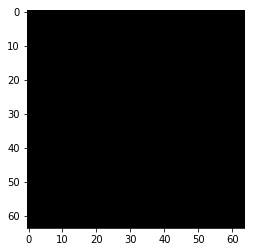

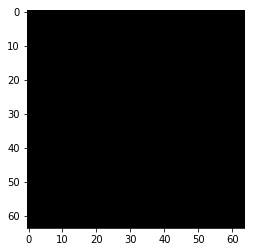

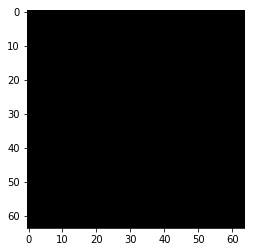

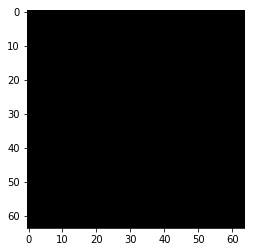

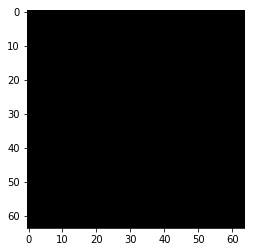

In [23]:
%matplotlib inline

def evalLetters(feed):
    predict_, target_, predict_lengths_, target_lengths_ = sess.run(
        [letter_prediction_infer,
         letter_targets,
         final_seq_lengths,
         letter_targets_length],
        feed)
    for i, (inp, pred) in enumerate(zip(target_, predict_)):
        print("Expected images:", target_lengths_[i])
        for x in range(len(inp)):
            implt(inp[x].reshape((64, 64)), 'gray')
        print("Predicted images:", predict_lengths_[i])
        for x in range(len(pred)):
            implt(pred[x].reshape((64, 64)), 'gray')
        if i >= 0:
            break
            
fd_test = test_iterator.next_feed(BATCH_SIZE)
fd = train_iterator.next_feed(BATCH_SIZE, words=False, train=False)

evalLetters(fd_test)
evalLetters(fd)